Proyecto final: Identificación de tumores cerebrales
Mariana Zúñiga Sánchez

In [3]:
import pandas as pd
import seaborn as sns
import sys
import numpy as np 
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
train_path=  '/Users/marianazuniga/Documents/GitHub/neuro 2/S06_proyecto/dataset/Training'
test_path = '/Users/marianazuniga/Documents/GitHub/neuro 2/S06_proyecto/dataset/Testing'

In [ ]:
Análisis de dataset (AED)

In [5]:
# Función para contar imágenes en cada carpeta
def count_images_in_folders(path):
    class_counts = {}
    for folder in os.listdir(path):
        full_path = os.path.join(path, folder)
        if os.path.isdir(full_path):
            count = len([f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))])
            class_counts[folder] = count
    return class_counts

# Contar imágenes en Training y Testing
train_counts = count_images_in_folders(train_path)
test_counts = count_images_in_folders(test_path)

print("Conteo en Training:")
print(train_counts)
print("\nConteo en Testing:")
print(test_counts)

Conteo en Training:
{'pituitary': 1457, 'notumor': 1595, 'glioma': 1321, 'meningioma': 1339}

Conteo en Testing:
{'pituitary': 300, 'notumor': 405, 'glioma': 300, 'meningioma': 306}


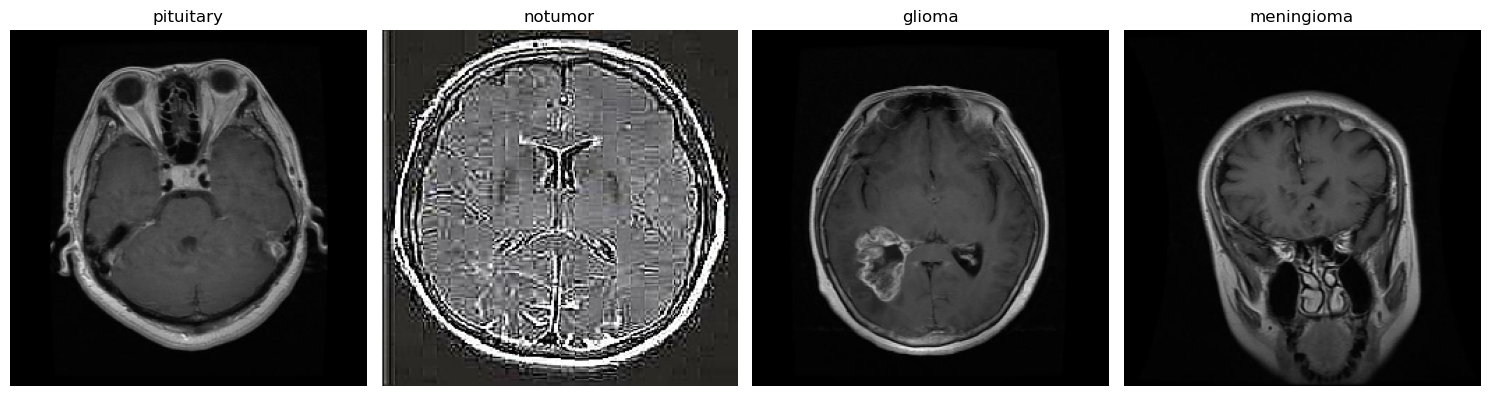

In [6]:
def show_sample_images(path, num_samples=4):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    classes = os.listdir(path)
    for i, clase in enumerate(classes):
        img_folder = os.path.join(path, clase)
        sample_img = os.listdir(img_folder)[:1]
        if sample_img:
            img_path = os.path.join(img_folder, sample_img[0])
            img = image.load_img(img_path, target_size=(256, 256))
            img_array = image.img_to_array(img) / 255.
            axes[i].imshow(img_array)
            axes[i].set_title(clase)
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_path)

/var/folders/51/q0m3j69d6rz8zc1pdvfkk6tm0000gn/T/ipykernel_89659/3412521911.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Clase', y='Cantidad', data=df_train, palette="viridis")
/var/folders/51/q0m3j69d6rz8zc1pdvfkk6tm0000gn/T/ipykernel_89659/3412521911.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Clase', y='Cantidad', data=df_test, palette="magma")


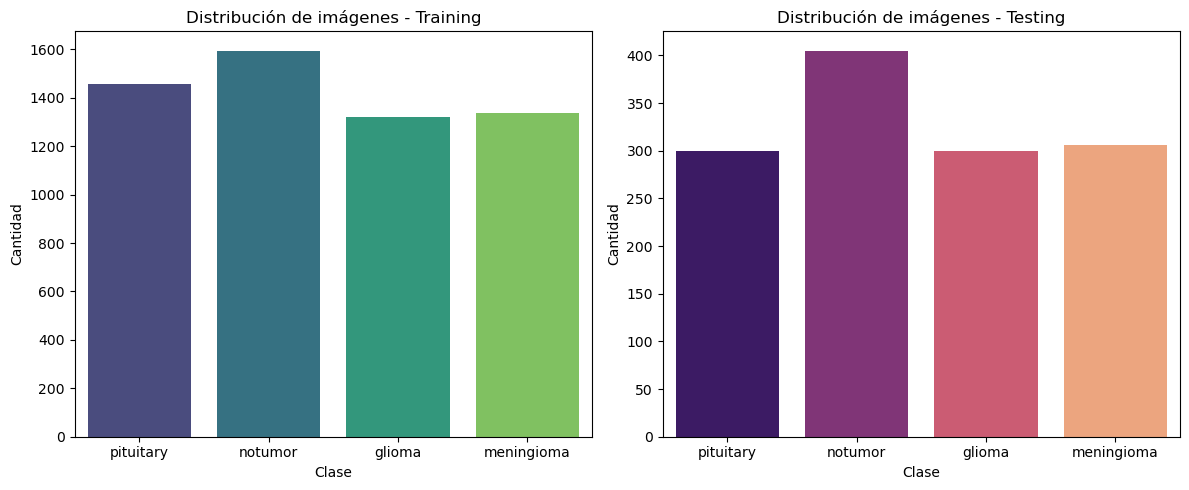

In [7]:
# Convertir conteo a DataFrame
df_train = pd.DataFrame(list(train_counts.items()), columns=['Clase', 'Cantidad'])
df_test = pd.DataFrame(list(test_counts.items()), columns=['Clase', 'Cantidad'])

# Gráficos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Clase', y='Cantidad', data=df_train, palette="viridis")
plt.title('Distribución de imágenes - Training')

plt.subplot(1, 2, 2)
sns.barplot(x='Clase', y='Cantidad', data=df_test, palette="magma")
plt.title('Distribución de imágenes - Testing')

plt.tight_layout()
plt.show()

In [8]:
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())

print(f"\nTotal de imágenes en Training: {total_train}")
print(f"Total de imágenes en Testing: {total_test}")
print(f"Proporción Training/Testing: {total_train / (total_train + total_test):.2%} / {total_test / (total_train + total_test):.2%}")

for clase in train_counts:
    prop_train = train_counts[clase] / total_train
    prop_test = test_counts.get(clase, 0) / total_test
    print(f"\nClase '{clase}':")
    print(f" - En training: {train_counts[clase]} ({prop_train:.2%})")
    print(f" - En testing: {test_counts.get(clase, 0)} ({prop_test:.2%})")


Total de imágenes en Training: 5712
Total de imágenes en Testing: 1311
Proporción Training/Testing: 81.33% / 18.67%

Clase 'pituitary':
 - En training: 1457 (25.51%)
 - En testing: 300 (22.88%)

Clase 'notumor':
 - En training: 1595 (27.92%)
 - En testing: 405 (30.89%)

Clase 'glioma':
 - En training: 1321 (23.13%)
 - En testing: 300 (22.88%)

Clase 'meningioma':
 - En training: 1339 (23.44%)
 - En testing: 306 (23.34%)


Identificación del tipo de problema: clasificación de imágenes 

In [9]:
img_size = (256, 256)
batch_size = 32
num_classes = 4
epochs = 15

In [10]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen_test = ImageDataGenerator(rescale=1./255)

train_dataset = datagen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_dataset = datagen_test.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_dataset.class_indices.keys())
print("Clases detectadas:", class_names)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']


Creación de modelo CNN

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088,452 (49.93 MB)

 Trainable params: 13,088,452 (49.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stop]
)

# Perdón feer no cargaron las 15 iteraciones, mi idea era con 20 y casi se muere mi compu :(((

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 172s 955ms/step - accuracy: 0.3711 - loss: 1.2402 - val_accuracy: 0.5118 - val_loss: 1.3520
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6543 - loss: 0.8399 - val_accuracy: 0.6659 - val_loss: 1.0176
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.7004 - loss: 0.7327 - val_accuracy: 0.7025 - val_loss: 0.9112
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7421 - loss: 0.6686 - val_accuracy: 0.7452 - val_loss: 0.6531
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.7547 - loss: 0.6310 - val_accuracy: 0.7582 - val_loss: 0.6325
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.7639 - loss: 0.5897 - val_accuracy: 0.7376 - val_loss: 0.7718
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.7664 - loss: 0.5979 - val_accuracy: 0.7613 - val_loss: 0.6314
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7891 - loss: 0.5555 - val_a

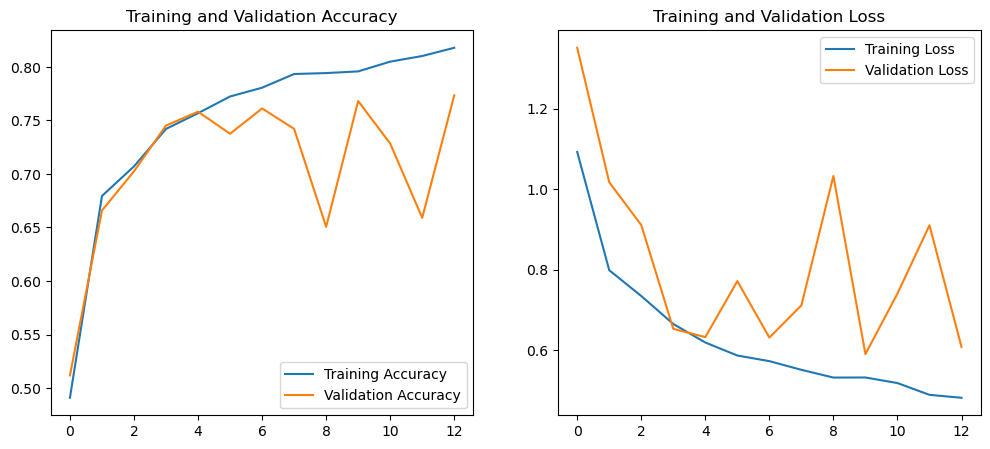

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Evaluación de resultados acorde al problema (clasificación: accuracy, precision, recall, f1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step
Informe de clasificación:
              precision    recall  f1-score   support

      glioma       0.76      0.77      0.76       300
  meningioma       0.66      0.42      0.51       306
     notumor       0.75      0.98      0.85       405
   pituitary       0.87      0.84      0.86       300

    accuracy                           0.77      1311
   macro avg       0.76      0.75      0.75      1311
weighted avg       0.76      0.77      0.75      1311



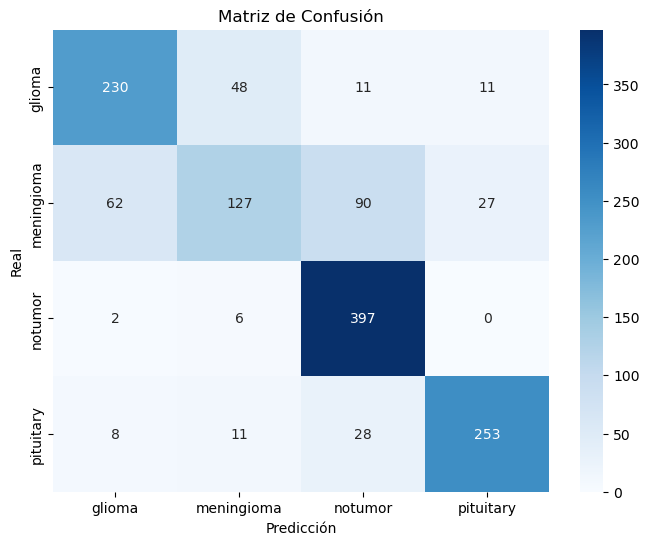

In [14]:
# Obtener predicciones y etiquetas reales
test_dataset.reset()
preds = model.predict(test_dataset)
y_true = test_dataset.classes
y_pred = preds.argmax(axis=1)

# Informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

El modelo tiene una accuracy del 77% , lo que indica un rendimiento razonable, pero con margen de mejora.
Hay variaciones claras entre clases , lo cual sugiere que el modelo no está aprendiendo igual de bien todas las categorías.

In [15]:
# Reiniciar el generador y obtener todas las imágenes y etiquetas
test_dataset.reset()
X_test = []
y_true = []
filenames = []

for images, labels in test_dataset:
    X_test.append(images)
    y_true.extend(np.argmax(labels, axis=1))
    filenames.extend(test_dataset.filenames)
    if len(X_test) * batch_size >= test_dataset.samples:
        break

X_test = np.vstack(X_test)
y_true = np.array(y_true)

Prueba del modelo

In [16]:
# Predecir sobre todo el conjunto de test
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

# Probabilidades para mostrar confianza
confidences = np.max(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step


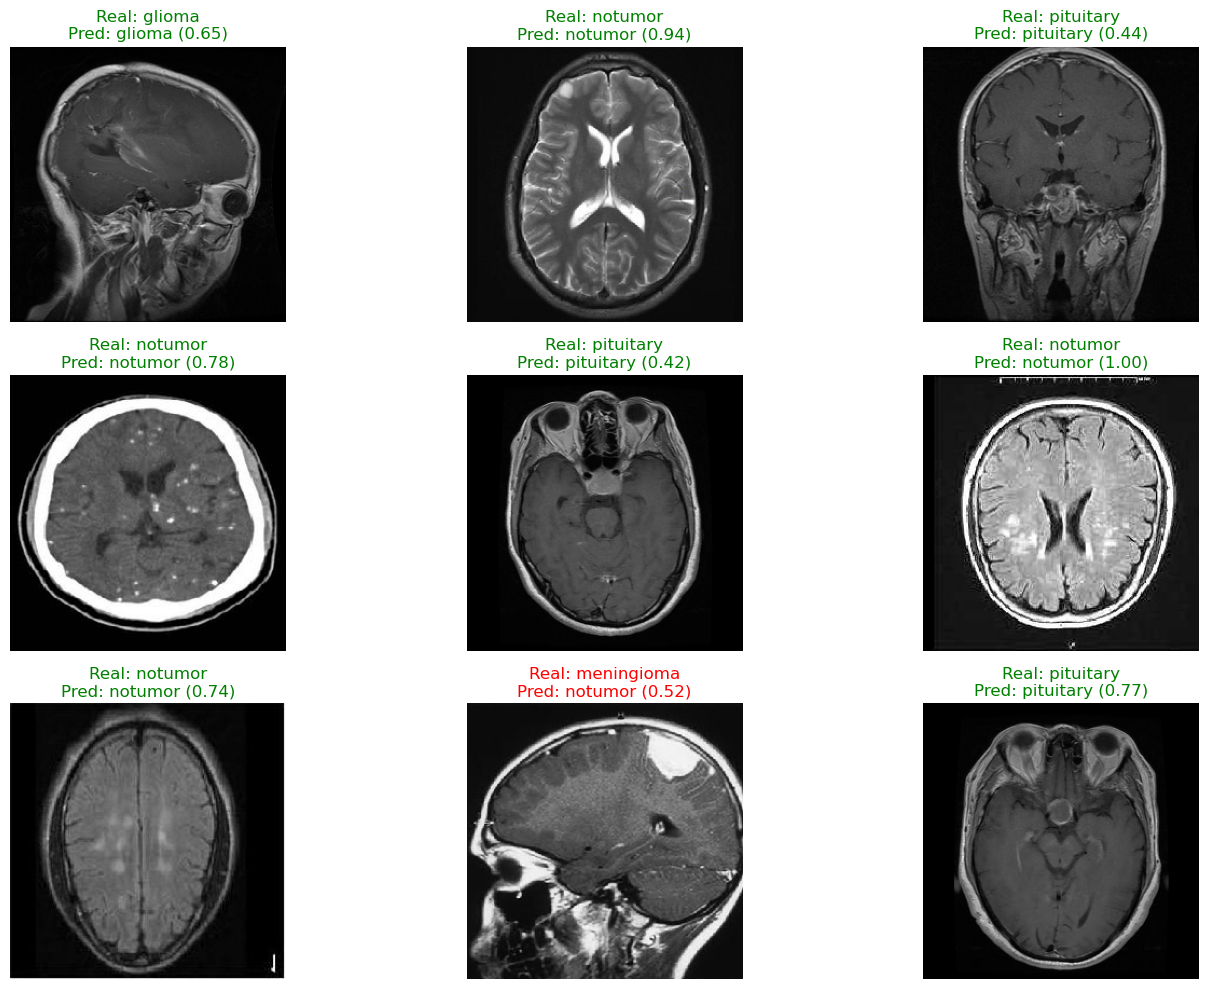

In [17]:
def mostrar_resultados(X, y_true, y_pred, confianzas, class_names, num_muestras=9):
    indices = np.random.choice(len(X), num_muestras, replace=False)
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        img = X[idx]
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        conf = confianzas[idx]

        color = 'green' if true_label == pred_label else 'red'

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Real: {true_label}\nPred: {pred_label} ({conf:.2f})", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

mostrar_resultados(X_test, y_true, y_pred, confidences, class_names, num_muestras=9)

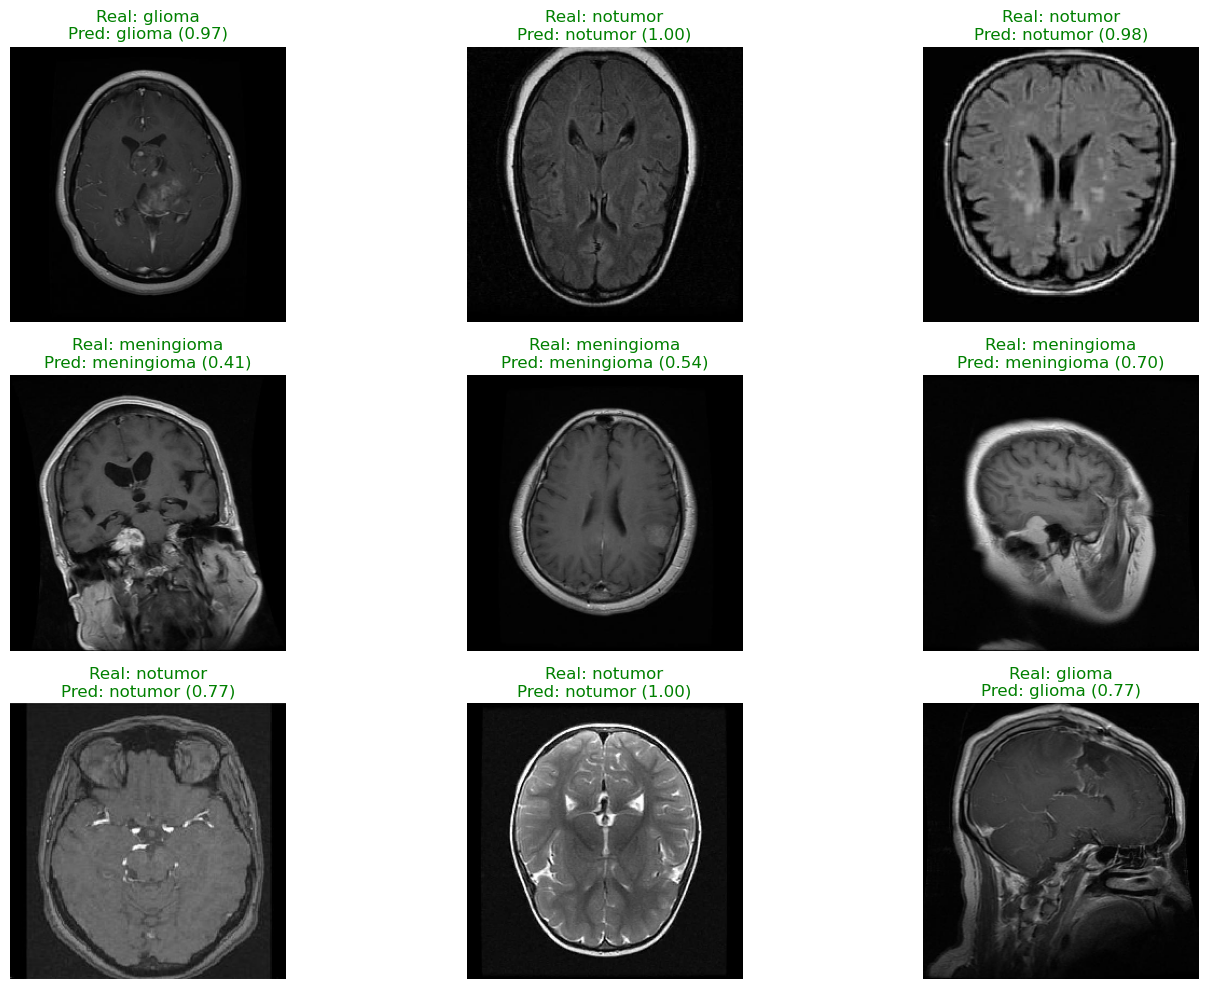

In [19]:
def mostrar_resultados(X, y_true, y_pred, confianzas, class_names, num_muestras=9):
    indices = np.random.choice(len(X), num_muestras, replace=False)
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        img = X[idx]
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        conf = confianzas[idx]

        color = 'green' if true_label == pred_label else 'red'

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Real: {true_label}\nPred: {pred_label} ({conf:.2f})", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

mostrar_resultados(X_test, y_true, y_pred, confidences, class_names, num_muestras=9)

Meningioma es la clase más confundida : Muchos casos son confundidos con notumor (90) y glioma (62).
Notumor es bien identificada : Solo 8 falsos negativos (casos donde se dijo que era tumor cuando no lo era).
Pituitario y glioma tienen menos confusiones entre sí, lo que muestra que el modelo sí logra diferenciarlos bien.


In [20]:
print("Informe de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nMatriz de confusión:")
print(confusion_matrix(y_true, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

      glioma       0.76      0.77      0.76       300
  meningioma       0.66      0.42      0.51       306
     notumor       0.75      0.98      0.85       405
   pituitary       0.87      0.84      0.86       300

    accuracy                           0.77      1311
   macro avg       0.76      0.75      0.75      1311
weighted avg       0.76      0.77      0.75      1311


Matriz de confusión:
[[230  48  11  11]
 [ 62 127  90  27]
 [  2   6 397   0]
 [  8  11  28 253]]


In [ ]:
Glioma : Rendimiento bueno, pero puede mejorar.
Meningioma: Peor rendimiento. Bajo recall significa que el modelo falla al identificar muchos casos reales de meningioma.
No tumor: Muy buen recall, casi siempre reconoce bien los casos sin tumor.
Pituitario: Buen equilibrio entre precisión y recall. De las mejores clases.